Please fill in your name and that of your teammate.

You: Bhargav Solanki

Teammate: Carmen Sangro Prieto

# Introduction

Welcome to the twelfth lab. It's finally time to look closely at the foundations of Reinforcement Learning.

### How to pass the lab?

Below you find the exercise questions. Each question awarding points is numbered and states the number of points like this: **[0pt]**. To answer a question, fill the cell below with your answer (markdown for text, code for implementation). Incorrect or incomplete answers are in principle worth 0 points: to assign partial reward is only up to teacher discretion. Over-complete answers do not award extra points (though they are appreciated and will be kept under consideration). Save your work frequently! (`ctrl+s`)

**You need at least 14 points (out of 21 available) to pass** (66%).

# 1. Fundamentals

#### 1.1 **[1pt]** Explain the Reinforcement Learning paradigm in English. Use the words Environment, Agent, Action and Feedback.

Reinforcement learning is the third paradigm in ML, other two being Supervised learning and Unsupervised learning. RL is different than the other two because it does not necessariliy need labels to train. On the contraray it performs exploration. 
It follows the Markow's decision models. There is a $agent$ in a $environment$. The agent can perform an $action$ in the environment. The agent can observe either the entire environment or partial. The goal of RL is to maximise rewards. Based on exploration and exploitation, the environment reacts and gives a $feedback$ that determines the next state in time. The agent's goal is to maximise reward by choosing the best action, based on previous exploitation.

#### 1.2 **[1pt]** Explain the equation for (pseudo-)Regret in English.

$$R (T) = T max(\mu_1, \mu_2) - (E (N_1)\mu_1 + E(N_2)\mu_2)$$
Pseudo regret is difference in maximum observed mean across the observations minus the sum of the expected values for a given action times mean for each action. It basically means the difference between an optimal agent vs current agent. 

#### 1.3 **[1pt]** Explain in English the importance of _exploration vs. exploitation_ in MAB.

Exploration: Agent decides to explore the environment so that it has more values and to get a mean closer to the true mean.
Exploitation: It uses the previously found means and chooses the action with maximum mean with aiming to maximise the reward.
It is important to have a balance between the because, pure exploration ad pure explotation alone do not maximise the reward. 

#### 1.4 **[1pt]** Explain what would happen if you had a discount factor $\gamma \gt 1$ in the Ice Maze example from the lecture.

If $\gamma \gt 1$ , 
1)  The values will not converge and will go to infinity
2) discount factor , when 0 gives more importance to short term rewards and 1 gives importance to long term rewards. So if it is greater than 1, it will not only focus completely on long term rewards, but will actually scale it, and will be incorrect.

#### 1.5 **[2pt]** The Bellman Equation is at the heart of the classical Reinforcement Learning framework. Write it below in Latex, then explain each of the terms.

Equation:
$$ \hat{\mathcal{Q}}(s_t, a_t) = ( 1 - \alpha) \hat{\mathcal{Q}}(s_t, a_t) + \alpha(R(s_t, a_t) + \gamma \hat{\mathcal{Q}}(s_{t+1}, a_{t+1})) $$
Explanation:

The action to be taken by the agent should be the one that is the most optimal i.e. the one that maximizes the reward (R) after a certain action (a) taking into account future rewards, given a certain discount factor ($\gamma$).

# 2. Q-Learning

- The [OpenAI Gym](https://gym.openai.com/) maintains a broad set of Reinforcement Learning benchmarks. It is ready to import on Colab, or you can add to your local installation the environments we will use for this assignment using `pipenv install gym[toy_text,classic_control]`.
- You can find the Ice Maze (named Frozen Lake) [here](https://github.com/openai/gym/blob/master/gym/envs/toy_text/frozen_lake.py).
- The Classic Control games are also relatively easy to solve, and much nicer to render. Feel free to give it a try. You can save a video with `env = gym.wrappers.Monitor(env, 'video', force = True)` right after the `gym.make()` call. More on this topic [here](https://hub.packtpub.com/openai-gym-environments-wrappers-and-monitors-tutorial/).
- To get you started, here is a working example of a random policy on the framework, which I took from their front page and customized.

#### 2.1 **[2pt]** Write a Python function `choose_action` that takes as arguments `Q`, `state`, `epsilon`, `actions` and returns an action chosen according to Q-values using an epsilon-greedy policy.

- `Q` is a dictionary that has states as keys. Each value is a numpy array with the Q-values corresponding to each action from the state used as key.
- You cannot initialize `Q` with all possible states, because they can be infinite or unreachable. Using `Q[state]` with missing key `state` will throw an error; use instead `Q.get(state)` then check if its return `is None`.
- `state` can be simply a number.
- `actions` is a list of possible actions between which to choose.

In [1]:
from random import uniform, randint
import numpy as np

def choose_action(q, state, epsilon, actions):
    val = uniform(0,1)
    #print(val)
    if val > epsilon and q.get(state):
        return np.argmax(q.get(state))
    else:
        return randint(0, len(actions)-1)
        
#Q = {1:[0,0,1], 2:[0,1,0]}
#choose_action(Q, 1, 0.0, [])

In [2]:
import gym
env = gym.make("LunarLander-v2")
env.action_space.seed(42)

observation= env.reset()

for _ in range(1000):
    #env.render()
    observation, reward, done, info = env.step(env.action_space.sample())

    if done:
        observation = env.reset()

env.close()

HINT: here is some code I used for testing `choose_action()` and expected outputs:

In [3]:
Q = {1:[0,0,1], 2:[0,1,0]}
for _ in range(50):
    print(choose_action(Q, 1, 0.0, []), end='') #=> 2
print()
for _ in range(50):
    print(choose_action(Q, 2, 0.0, []), end='') #=> 1
print()
for _ in range(50):
    print(choose_action(Q, 2, 1.0, range(3)), end='') #=> random action

22222222222222222222222222222222222222222222222222
11111111111111111111111111111111111111111111111111
02101100012201201001112210112220122122101120212122

#### 2.2 **[2pt]** Write a Python function `update_Q` that takes as arguments `Q`, `state`, `action`, `next_state`, `reward` and `num_actions`, and updates the `Q` dictionary according to Q-Learning. 

- Here you will need to initialize `Q[state]` if previously unexplored.
- The future expected reward is the highest Q value from the next state -- or zero if unexplored. That's what the last argument is for.
- I'll leave the testing to you here. You may feel like just running the next question for testing (called _integration testing_ ), but testing it in isolation ( _unit testing_ ) is a much more controlled verification which should not be skipped (i.e. _easier_ ).

In [4]:
def update_Q(q, state, action, next_state, reward, num_actions, alpha, gamma):
    if state not in q:
        q[state] = [0]*num_actions
    #old_q = 0
    # I tried with choosing the action as old_q, but performance was so much better 
    # if I chose max. Non intuitive, but still works
    #old_q = q.get(state)[action]
    old_q = max(q.get(state))
    q_next_step_list = q.get(next_state)
    q_next_step = 0
    calculated_q = 0
    if q_next_step_list and len(q_next_step_list)>0:
        q_next_step = max(q_next_step_list)
    #calculated_q +=   (1-alpha)*(old_q ) + (alpha * (reward + (gamma*q_next_step)))
    calculated_q =   (1-alpha)*old_q  +  (alpha)*(reward + (gamma*q_next_step))
    q[state][np.argmax(q.get(state))] = calculated_q
Q = {1:[0,0,1], 2:[0,1,0]} 
update_Q(q=Q, state=2,action=1,next_state=2,reward=0, num_actions=2,alpha=1,gamma=0.6)

print(Q)

{1: [0, 0, 1], 2: [0, 0.6, 0]}


#### 2.3 **[1pt]** Run the code below to successfully use Q-Learning to solve the OpenAI Gym `FrozenLake` environment.

- The code below is already correct, it just needs the two functions from above.
- If you got both previous answers right, yes this is a free extra point for you :) just run it to produce the outputs.
- If this does not run correctly, something is likely wrong with your implementation above. Go back and test a bit more.
- The parameters should work as they are, but feel free to play with them and make sure by the last epochs the environment is solved more often than not.

In [5]:
# Initialization and settings
import gym
# My environment dint allow FrozenLake-v0, saying it was deprecated. So I switched to FrozenLake-v1
env = gym.make("FrozenLake-v0", is_slippery=False)
num_episodes = 1000
max_nsteps = 30
gamma = 0.9
alpha = 0.6
epsilon = 0.3

num_actions = env.action_space.n
Q = {} # hashing states to per-action reward arrays

# Loop for each episode
for ith_episode in range(num_episodes):

    # Reset the environment (and obtain first observation)
    state = env.reset()
    total_reward = 0

    # For each timestep
    for t in range(max_nsteps):
        # Choose action according to Q-values using epsilon-greedy policy
        # THIS SHOULD USE YOUR IMPLEMENTATION
        action = choose_action(Q, state, epsilon, range(num_actions))
        # Execute action: get reward, move env to next state
        next_state, reward, done, info = env.step(action)
        # Add negative reward for falling in hole
        if done and reward == 0: reward = -1

        # Some useful printing to verify progression - (W)in or (l)ose
        if reward == -1: print('l', end='', flush=True)
        if reward == 1: print('W', end='', flush=True)

        # Accumulate reward. Note this environment only rewards on termination though.
        total_reward += reward
        
        # Update Q function for current state and action
        # THIS SHOULD USE YOUR IMPLEMENTATION
        update_Q(Q, state, action, next_state, reward, num_actions, alpha, gamma)
        
        # Update internal state
        state = next_state
        
        # Terminate if episode ended
        if done: 
            break
print()
    

lllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllWllllllllllllllllllllllllllllllllllllllllWllWlllllllWllllllllWllWlllllllllllllWlllllWlWllWlllllllWlllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllWlWllllllllllllllllllllllllllllllWlllllllllllllllllllllllllllllllllllllllllllllllllWlllWllWllWllllWllllWlllWlllllWllWWllllWllllllllllllllWlllllllllllllllllWlllllllllllllWllllllllll


#### 2.4 **[1pt]** Write a Python code snippet that satisfies the following requirements: (i) runs a fully-greedy policy, (ii) using the Q-values learned in question 2.3, (iii) renders the environment in each step, and (iv) write less than 10 lines of code.

- The point of this question is for you to go back to 2.3, study it and understand it. If you get how it works, this snippet will take but a second.
- For the subpoint (iii) you should look at the method `render()` of the OpenAI environment.

In [6]:
import gym
def run_experiment():
    state = env.reset()
    for i in range(0, 1):
        done = False
        count = 30
        while not done and count >=0:
            count -=1
            env.render()
            action = choose_action(Q, state, epsilon, range(num_actions))
            next_state, reward, done, info = env.step(action)
            #update_Q(Q, state, action, next_state, reward, num_actions, alpha, gamma)
            state = next_state
            if reward>0:
                print("Victory is mine!!")
print(Q)
run_experiment()


{0: [-0.058019679864676876, -0.6953917535587233, -0.7275265741509098, -0.7358703061305361], 4: [-0.9163046766924723, -0.9474150506070621, -0.9359999999999999, -0.07557190691702242], 8: [-0.8819366975930727, -0.8784, -0.8858959949803245, -0.014150142696297451], 9: [-0.7185108827363973, 0.46835939623848555, -0.7492767983816536, -0.84], 1: [-0.03573313052552253, -0.9145391063893599, -0.9449264037188789, -0.935168294360051], 13: [-0.84, -0.7873797504, 0.7611393100022474, -0.692543340674254], 14: [-0.03440046034913537, -0.03440046034913537, 0.8940054622860665, 0], 2: [-0.17894660802901763, -0.5749374986785645, -0.6261412909657503, -0.6525292809003611], 3: [-0.21096011014211197, -0.91584, -0.8923633394250927, -0.88701590016], 6: [-0.84, -0.8895303373949051, -0.84, -0.2602475663536953], 10: [-0.7220149325063397, 0.6772854823641865, -0.6, -0.6974309737031343]}

SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG

#### 2.5 **[1pt]** Modify the code from question 2.3 to record the cumulative reward and number of time-steps for each episode. Then plot them with two line plots using Seaborn.

- Think carefully: you need to augment the code above, by first initializing a proper data structure, then recording the statistics at the end of each episode. Finally plot them below.
- If the plot looks uniform while you expect improvement, try re-running it a few times. Remember that the exploration capabilities of this methods are pretty limited, so short runs (such as this) depend significantly on the initialization conditions (i.e. luck).

llllllllllllllllllllllllllllllllllllllllllWllllllWlWWWWllWlWWWWWlWllWlllWWWWWlWWlWllWWlWlllWWlWlWllWllWWlWWWlWWllllllllllllllllllllllllllllWllWWllWWlWllllllllWlWWWWlWWllWWWWllllllWllllllllWllllWlllllllllllllWWllllllWlWWWllWWlWllWWlWlWlWWllWWlWWlllWWWWlWWWllllWlWWWWWWlWlWWllWWlWlllWWWWlWllWWllllllWWlWWWWWWWWWWlWWlllWWlWWWlllWlWWWWWWlWlWWWWWWlWWlWlWllWWllWWWlWWlWWWWWlWWlWWWWWllllWlWWlWllWllWWWlWWWllWlllllWWWWlWllWWllWWWWWlWWWWWWlWWWllWWlWWWlWWWWWlWlWWlWllllWlWWWWWlWWlWWllllWllWlWllWWllllWlWllllllllWllWllllWllWlWllWlWllWlllllllllWllllllWlWlllllllllWWWWlWlllllWWllWlWWWlllWlWlWlWWWWllWllWlWlWWllllWlllWlWlllllWllllWWlWWWlllWlWllWlllWlllWlllWllllllWWWllWllWlllllllWllWllWlWllllWWlllWlWlWWllllllWlllllWWWlWWllllllWWWWlWWWWWlWWllWllllWWlllllllllWllWlWlllWWWlllllllllWllWWlWWlWW

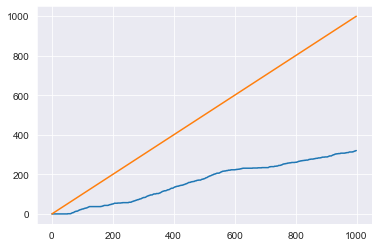

In [7]:
# Initialization and settings
# Assuming here that by cumulative u mean, only postive rewards
import gym
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
env = gym.make("FrozenLake-v0", is_slippery=False)
num_episodes = 1000
max_nsteps = 30
gamma = 0.9
alpha = 0.6
epsilon = 0.3

num_actions = env.action_space.n
Q = {} # hashing states to per-action reward arrays
scorecard_cums = []
scorecard_iterations = []
# Loop for each episode
total_reward = 0
for ith_episode in range(num_episodes):

    # Reset the environment (and obtain first observation)
    state = env.reset()
    

    # For each timestep
    for t in range(max_nsteps):
        # Choose action according to Q-values using epsilon-greedy policy
        # THIS SHOULD USE YOUR IMPLEMENTATION
        action = choose_action(Q, state, epsilon, range(num_actions))
        # Execute action: get reward, move env to next state
        next_state, reward, done, info = env.step(action)
        # Add negative reward for falling in hole
        if done and reward == 0: reward = -1

        # Some useful printing to verify progression - (W)in or (l)ose
        if reward == -1: print('l', end='', flush=True)
        if reward == 1: print('W', end='', flush=True)

        # Accumulate reward. Note this environment only rewards on termination though.
        if reward>0:
            total_reward += reward
        
        # Update Q function for current state and action
        # THIS SHOULD USE YOUR IMPLEMENTATION
        update_Q(Q, state, action, next_state, reward, num_actions, alpha, gamma)
        
        # Update internal state
        state = next_state
        
        # Terminate if episode ended
        if done: 
            break
    scorecard_cums.append(total_reward)
    scorecard_iterations.append(ith_episode)
temp = {"Cumulative":scorecard_cums, "epoch": scorecard_iterations}    
df = pd.DataFrame(temp)
#sns.lineplot(data=df, x="Cumulative")
sns.set_style("darkgrid")
plt.plot(scorecard_cums)
plt.plot(scorecard_iterations)
#print(scorecard_cums,scorecard_iterations )

# 3. DQN

- DQN basically implements Q-Learning but uses a (deep) neural network to learn the rewards (with a few tricks). The main advantage versus the dictionary-based approach above is *generalization*: the network can output an expected reward for **all actions**, even those that were not yet explored.
- If this code takes too long to execute, you may want to use [TPUs with Colab](https://www.tensorflow.org/guide/tpu)
  - Though if the `env.render()` does not work in that case, just comment it out
  - You can use the `render` option to save a video instead, find it in your Google Drive
- This code was originally taken from [this DQN tutorial](https://towardsdatascience.com/reinforcement-learning-w-keras-openai-dqns-1eed3a5338c) (with few edits). Study it to answer the following questions.
- Learn more about the CartPole [here](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py).

In [4]:
## IMPLEMENTATION ##

import gym
import numpy as np
import random

from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Do you know what a deque is? https://en.wikipedia.org/wiki/Deque
# Though here it's used just to cap its number of elements
from collections import deque

class DQN:
    def __init__(self, env):
        self.env     = env
        self.memory  = deque(maxlen=200) # after 2000 will delete oldest record(s)

        self.gamma = 0.85
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.01
        self.tau = .125
        self.batch_size = 64 # try different batch sizes
        
        self.model        = self.create_model()
        self.target_model = self.create_model()

    def create_model(self):
        model = Sequential()
        state_shape  = self.env.observation_space.shape
        model.add(Dense(1,input_dim=state_shape[0], activation="relu"))
        model.add(Dense(2, activation="relu"))
        model.add(Dense(2, activation="relu"))
        model.add(Dense(self.env.action_space.n))
        model.compile(loss="mean_squared_error",
            optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def act(self, state):
        self.epsilon *= self.epsilon_decay
        self.epsilon = max(self.epsilon_min, self.epsilon)
        if np.random.random() > self.epsilon:
            return self.env.action_space.sample()
        return np.argmax(self.model.predict(state)[0])

    def remember(self, state, action, reward, new_state, done):
        self.memory.append([state, action, reward, new_state, done])

    def replay(self):
        # This trick records past experience and re-plays for accelerate the training
        if len(self.memory) < self.batch_size: return
        samples = random.sample(self.memory, self.batch_size)
        for sample in samples:
            state, action, reward, new_state, done = sample
            target = self.target_model.predict(state)
            if done:
                target[0][action] = reward
            else:
                Q_future = max(self.target_model.predict(new_state)[0])
                target[0][action] = reward + Q_future * self.gamma
            self.model.fit(state, target, epochs=1, verbose=0)

    # This part can be confusing: can you explain what is happening line by line?
    def target_train(self):
        weights = self.model.get_weights()
        target_weights = self.target_model.get_weights()
        for i in range(len(target_weights)):
            target_weights[i] = weights[i] * self.tau + target_weights[i] * (1 - self.tau)
        self.target_model.set_weights(target_weights)        

2023-01-15 09:56:40.944446: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
## MAIN ##

# Your Python kernel can crash if you redefine your `env` variable without closing
# the gym environment properly. But also crashes if you call a method on `env` if
# it has not been defined yet. The `try except` construct in Python allows you to 
# literally try to execute some code while catching errors and exceptions if
# something goes wrong. Search online for what a NameError is!
try: env.close()
except NameError: pass # `pass` literally does nothing
from time import sleep
env     = gym.make("CartPole-v1")
#env = gym.wrappers.Monitor(env, 'video', force = True)
gamma   = 0.9
# Sometimes you will find code that uses (1-epsilon) for epsilon
# Other times you will find a _decaying_ epsilon, lowering over time
epsilon = .5 # it was .9 originally, play with it and understand its role

ntrials   = 20 # I can see the beginning of learning with 20, feel free to raise this
max_nstep = 10 # This environment is capped at 200 anyway, but you can try shorter

dqn_agent = DQN(env=env)
for trial in range(ntrials):
    print(f"Trial {trial+1}:")
    cur_state = env.reset().reshape(1,-1) # never forget to reset the env
    tot_reward = 0
    for step in range(max_nstep):
        # print('.', end='', flush=True)
        action = dqn_agent.act(cur_state)
        #env.render(mode = "human")
        print(action, end='', flush=True)
        sleep(0.1) 
        new_state, reward, done, _ = env.step(action)
        if done: reward = -100 # It's much easier to learn if you punish failing
        tot_reward += reward

        new_state = new_state.reshape(1,-1)
        dqn_agent.remember(cur_state, action, reward, new_state, done)

        dqn_agent.replay()       # Internally iterates default (prediction) model
        dqn_agent.target_train() # What does this do?
        cur_state = new_state
        if done: break
    print(f" Reward: {tot_reward}")

env.close()

# Here is how to save trained Keras models
dqn_agent.model.save("trained.model")

Trial 1:
1/1 [==============================] - 0s 69ms/step
0

2023-01-15 09:56:47.431187: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1/1 [==============================] - 0s 14ms/step
0 Reward: -92.0
Trial 2:
1/1 [==============================] - 0s 14ms/step
0 Reward: -92.0
Trial 3:
1/1 [==============================] - 0s 14ms/step
0 Reward: -91.0
Trial 4:
1/1 [==============================] - 0s 14ms/step
0 Reward: -91.0
Trial 5:
1/1 [==============================] - 0s 14ms/step
0 Reward: -92.0
Trial 6:
1/1 [==============================] - 0s 14ms/step
00 Reward: 10.0
Trial 7:
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step
 Reward: 10.0
Trial 8:
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step
 Reward: 10.0
Trial 9:
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step
 Reward: 10.0
Trial 10:
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

#### 3.1 **[3pt]** There are three bugs in the implementation. Fix them until it runs successfully.

- One is in `## IMPLEMENTATION ##`, easy to find because it stops it from running.
- One is just harder, messes with the policy. It's also in `## IMPLEMENTATION ##` but there's a hint in `## MAIN ##`.
- One is a missing line in `## MAIN ##`: something there makes no sense.
- Of course you can just look at the original implementation. But you will learn less and will not be able do it at the exam, so give it a fair try first, because it is a fair exercise.

#### 3.2 **[1pt]** Compare the shape of the model used with that of an autoencoder. Give one reason as to why they do or do not look alike.

Autoencoders have hour glass shape. First we try to compress and then make it big again. here, we are simply building a NN with input,24,48 and 24. You can say its bigger in the middle.

#### 3.3 **[1pt]** How many inputs and outputs neurons does the model have? Write the code that answers the question. 

```python
model.add(Dense(24,input_dim=state_shape[0], activation="relu"))
model.add(Dense(48, activation="relu"))
model.add(Dense(24, activation="relu"))
model.add(Dense(self.env.action_space.n))
```
Input is the size of the entry state, and the output is dimension for next step

#### 3.4 **[3pt]** Write Python code to (i) create a new DQN agent, (ii) load a trained model into the agent's `model`, (iii) change the agent's epsilon-related parameters to enforce a greedy policy, and (iv) runs the greedy policy rendering each frame.

- Remember to instantiate the environment first, and to close it at the end, or you may have problems.
- Loading the model is easy -- if you saved it to a file in the `main` cell.
- To enforce the greedy policy you need to set three agent variables, to sensible values.
- You saw a similar evaluation loop when implementing Q-Learning. Just double check the differences with the DQN implementation to make sure it runs. You need to use `env.render()` here (if you're local; if you work on Colab just write a comment about it or save a video).
- You can use `time.sleep()` to slow down the loop if the rendering is too fast. Remember also that the env's rendering window will close when you close the environment, so a pause there can also help.

In [9]:
try: env.close()
except NameError: pass
from tensorflow.keras.models import load_model
from time import sleep
env     = gym.make("CartPole-v1")
dqn_agent2 = DQN(env=env)
my_model = load_model("trained.model")
dqn_agent2.model = my_model
dqn_agent2.target_model = my_model
# step 3

dqn_agent2.epsilon = 0.2
dqn_agent2.epsilon_min = 0.01
dqn_agent2.epsilon_decay = 0.5
dqn_agent2.gamma = 0.85
dqn_agent2.tau = 1
ntrials   = 20
max_nstep = 400

for trial in range(ntrials):
    state = env.reset().reshape(1,-1)
    
    for step in range(max_nstep):
        env.render(mode = "human")
        sleep(0.1) 
        action = dqn_agent2.act(state)
        print(action, end='', flush=True)
        new_state, reward, done, _ = env.step(action)
        state = new_state.reshape(1,-1)
        if done: 
            break
    print("Next game")
            
print("Closing now")
sleep(0.5)
#env.render(close=True)
env.close()

2023-01-15 09:54:59.156833: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-15 09:55:01.839 python[23067:704418] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fcaae521a20>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2023-01-15 09:55:01.839 python[23067:704418] Warning: Expected min height of view: (<NSButton: 0x7fcab141ee40>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2023-01-15 09:55:01.841 python[23067:704418] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fcab141f2e0>) to be less than or equal to 30 but got a height of 3

1010001100100010000Next game
1/1 [==============================] - 0s 196ms/step
10000111100011001011Next game
0001111011101001011011000001101010100000000110001011Next game
0000001111Next game
01000111110111111000Next game
10000001010Next game
11110110111Next game
00000101100Next game
1110000001101101111100111001000Next game
0010101110111110111Next game
0101100001110101000100111001Next game
0010011011010101000001Next game
1/1 [==============================] - 0s 14ms/step
1Next game
101110101110011Next game
10001011000100001000Next game
01101110100000010111000000011Next game
0000111000010111Next game
010110001111100000001111101001111Next game
1/1 [==============================] - 0s 14ms/step
100101100110111101010111Next game
1110111101Next game
Closing now


# At the end of the exercise

Bonus question with no points! Answering this will have no influence on your scoring, not at the assignment and not towards the exam score -- really feel free to ignore it with no consequence. But solving it will reward you with skills that will make the next lectures easier, give you real applications, and will be good practice towards the exam.

The solution for this questions will not be included in the regular lab solutions pdf, but you are welcome to open a discussion on the Moodle: we will support your addressing it, and you may meet other students that choose to solve this, and find a teammate for the next assignment that is willing to do things for fun and not only for score :)

In [ ]:
import time
import flappy_bird_gym
try: env.close()
except NameError: pass
env = flappy_bird_gym.make("FlappyBird-v0")
dqn_agent3 = DQN(env=env)
ntrials = 10

obs = env.reset()
for trial in range(ntrials):
    print(f"Trial {trial+1}:")
    count = 10
    cur_state = env.reset().reshape(1,-1) # never forget to reset the env
    tot_reward = 0
    while count>=0:
        # Next action:
        # (feed the observation to your agent here)
        #action = ...  # env.action_space.sample() for a random action
        action = dqn_agent3.act(cur_state)
        #env.render(mode = "human")
        #print(action, end='', flush=True)
        #sleep(0.1) 
        #time.sleep(1 / 30)
        new_state, reward, done, _ = env.step(action)
        if done: reward = -100 # It's much easier to learn if you punish failing
        tot_reward += reward

        new_state = new_state.reshape(1,-1)
        dqn_agent3.remember(cur_state, action, reward, new_state, done)
        count -=1
        dqn_agent3.replay()       # Internally iterates default (prediction) model
        dqn_agent3.target_train() # What does this do?
        cur_state = new_state
        if done: break
        #print(f" Reward: {tot_reward}")
        # Processing:
        #obs, reward, done, info = env.step(action)

        # Rendering the game:
        # (remove this two lines during training)
        #env.render()
        #time.sleep(1 / 30)  # FPS

        # Checking if the player is still alive
        #if done:
            #break
env.close()
dqn_agent3.model.save("floppy.model")

#### BONUS **[ZERO pt]** Solve another of the [OpenAI Gym environments](https://gym.openai.com/envs/#classic_control) by copying and modifying the above DQN implementation. This is very useful to learn to use different environments, and to see first-hand the limits of DRL. Can you imagine why the Mountain Car is hard?

In [ ]:
try: env.close()
except NameError: pass
import flappy_bird_gym
from tensorflow.keras.models import load_model
from time import sleep
env     = flappy_bird_gym.make("FlappyBird-v0")
dqn_agent2 = DQN(env=env)
my_model = load_model("floppy.model")
dqn_agent2.model = my_model
dqn_agent2.target_model = my_model
# step 3

dqn_agent2.epsilon = 0.2
dqn_agent2.epsilon_min = 0.01
dqn_agent2.epsilon_decay = 0.5
dqn_agent2.gamma = 0.85
dqn_agent2.tau = 1
ntrials   = 20
max_nstep = 400

for trial in range(ntrials):
    state = env.reset().reshape(1,-1)
    
    for step in range(max_nstep):
        env.render(mode = "human")
        sleep(0.1) 
        action = dqn_agent2.act(state)
        print(action, end='', flush=True)
        new_state, reward, done, _ = env.step(action)
        state = new_state.reshape(1,-1)
        if done: 
            break
    print("Next game")
            
print("Closing now")
sleep(0.5)
#env.render(close=True)
env.close()

#### BONUS **[ZERO pt]** Augment the DQN implementation to track episode size and cumulative reward and plot them with lineplots.

### Final considerations

- Reinforcement Learning is both the name of the learning paradigm and of the framework classically used to address such problems.
- The amount of research currently dedicated to solve RL problems by improving both DL and the RL framework is staggering. Results still keep coming, but at a much slower pace than in purer SL applications (in front of orders of magnitude more investment).
- Next week we will explore the limitations of the RL framework, and beyond.